In [87]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
import torch.nn as nn

from matplotlib.colors import ListedColormap

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression, Lasso, LogisticRegression, SGDClassifier

from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, classification_report, accuracy_score

import warnings
warnings.filterwarnings("ignore")


In [88]:
#Pipeline
df = pd.read_csv('startup_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 923 entries, 0 to 922
Data columns (total 49 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                923 non-null    int64  
 1   state_code                923 non-null    object 
 2   latitude                  923 non-null    float64
 3   longitude                 923 non-null    float64
 4   zip_code                  923 non-null    object 
 5   id                        923 non-null    object 
 6   city                      923 non-null    object 
 7   Unnamed: 6                430 non-null    object 
 8   name                      923 non-null    object 
 9   labels                    923 non-null    int64  
 10  founded_at                923 non-null    object 
 11  closed_at                 335 non-null    object 
 12  first_funding_at          923 non-null    object 
 13  last_funding_at           923 non-null    object 
 14  age_first_

In [89]:
#dropping cols, encoding

cols_to_drop = ['Unnamed: 0', 'Unnamed: 6', 'object_id', 'id', 'state_code.1', 'state_code', 'city', 'latitude', 'longitude', 'zip_code', 'name', 'category_code', 'closed_at', 'labels']
df2 = df.drop(columns=cols_to_drop, errors="ignore")

object_cols = df2.select_dtypes(include=["object"]).columns[:3]

for col in object_cols:
    df2[col] = pd.to_datetime(df2[col], errors="coerce") 
    df2[col] = df2[col].view("int64")


df2.info()
col_names = df2.columns.tolist()

impute_cols = ['age_first_milestone_year', 'age_last_milestone_year']
scale_cols = [col for col in df2.columns[0:11] if col not in impute_cols]+[ 'avg_participants']
#will be applying scaler to all features except for categorical features

df2 = pd.get_dummies(df2, columns=['status'], drop_first=True)
df2.info()
#encoding status

# print("cols in df2:", df2.columns.tolist())
# print("impute columns:", impute_cols)
# print("scale columns:", scale_cols)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 923 entries, 0 to 922
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   founded_at                923 non-null    int64  
 1   first_funding_at          923 non-null    int64  
 2   last_funding_at           923 non-null    int64  
 3   age_first_funding_year    923 non-null    float64
 4   age_last_funding_year     923 non-null    float64
 5   age_first_milestone_year  771 non-null    float64
 6   age_last_milestone_year   771 non-null    float64
 7   relationships             923 non-null    int64  
 8   funding_rounds            923 non-null    int64  
 9   funding_total_usd         923 non-null    int64  
 10  milestones                923 non-null    int64  
 11  is_CA                     923 non-null    int64  
 12  is_NY                     923 non-null    int64  
 13  is_MA                     923 non-null    int64  
 14  is_TX     

In [90]:
#splitting data

x = df2.iloc[:,0:34]
y = df2['status_closed']

#x.info()

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2, random_state=27)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=.2, random_state=27)

x_train = x_train.astype(float)
x_test = x_test.astype(float)
x_val = x_val.astype(float)

y_train = y_train.astype(float)
y_test = y_test.astype(float)
y_val = y_val.astype(float)


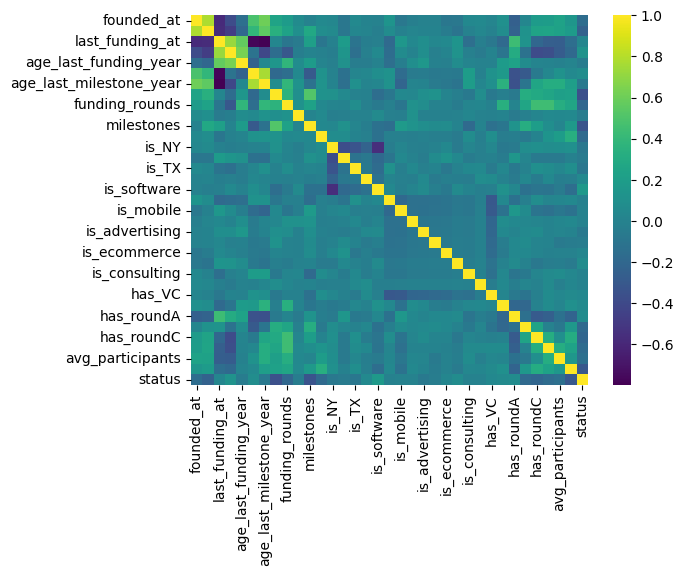

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 923 entries, 0 to 922
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   founded_at                923 non-null    object
 1   first_funding_at          923 non-null    object
 2   last_funding_at           923 non-null    object
 3   age_first_funding_year    923 non-null    object
 4   age_last_funding_year     923 non-null    object
 5   age_first_milestone_year  923 non-null    object
 6   age_last_milestone_year   923 non-null    object
 7   relationships             923 non-null    object
 8   funding_rounds            923 non-null    object
 9   funding_total_usd         923 non-null    object
 10  milestones                923 non-null    object
 11  is_CA                     923 non-null    object
 12  is_NY                     923 non-null    object
 13  is_MA                     923 non-null    object
 14  is_TX                     

In [91]:
#pipeline

impute_pl = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ("impute", impute_pl, impute_cols),
        ("scale", StandardScaler(), scale_cols)
    ],
    remainder="passthrough" #other cols stay the same
)

df2_tf = preprocessor.fit_transform(df2)
df2_tf = pd.DataFrame(df2_tf, columns=col_names)


#dropping columns with a high corr
threshold = .8
corr_matrix = df2_tf.corr()
sns.heatmap(corr_matrix, annot=False, cmap="viridis")
plt.show()

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr_features = [
    column for column in upper.columns if any(upper[column] > threshold)
]
df_tf = df2_tf.drop(columns=high_corr_features, errors='ignore')
df_tf.info()

print(high_corr_features)

model score: 0.770


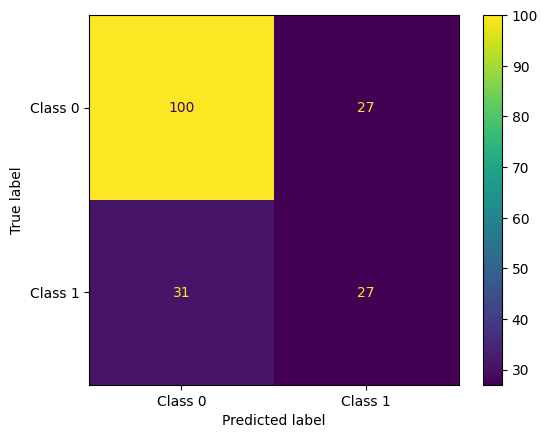

In [92]:
clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression())]
)



clf.fit(x_train, y_train)
print("model score: %.3f" % clf.score(x_val, y_val))  # average accuracy

y_pred=clf.predict(x_test)
cm = confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
disp.plot()

In [ ]:
accuracy = accuracy_score(y_test, y_pred)

precision = precision_score(y_test, y_pred)

recall = recall_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred)

print(f"Model 1: Accuracy={accuracy:.3f}, Precision={precision:.3f}, Recall={recall:.3f}, F1={f1:.3f}")

y_train_pred = clf.predict(x_train)

r2 = r2_score(y_test, y_pred)
print("r^2:", r2)
r22 = r2_score(y_train, y_train_pred)
print("r^2 train:", r22)
#both r2 worse than baseline


mse = mean_squared_error(y_test, y_pred)
print("MSE test:", mse)
#mse is worse than baseline mse, rip


mse2 = mean_squared_error(y_train, y_train_pred)
print("MSE train:", mse2)
#mse test also worse than baseline, but not by as much like with r2

#gonna test this with more models n see now

Model 1: Accuracy=0.686, Precision=0.500, Recall=0.466, F1=0.482
r^2: -0.45669291338582685
r^2 train: -0.04547269641609253
MSE test: 0.31351351351351353
MSE train: 0.24067796610169492


In [94]:
y_baseline = [y_train.mean()] * len(y_test)

# MSE for the baseline
baseline_mse = mean_squared_error(y_test, y_baseline)
print("Baseline MSE:", baseline_mse)

Baseline MSE: 0.21732121089776935


In [ ]:
#perceptron-adaline
class Adaline:
    def __init__(self, lr=0.01, n_epoch=150):
        self.lr = lr
        self.n_epoch = n_epoch
        self.weight = None
        self.bias = None
    
    def __func__(self, x):
        return np.dot(x, self.weight) + self.bias
    
    def fit(self, x, y):
        self.weight=np.zeros(x.shape[1])
        self.bias=0

        for _ in range(self.n_epoch):
            output=self.__func__(x)
            error = output-y
            dw = 2*np.dot(error, x)/x.shape[0]
            db = 2*error.mean()

            self.weight = self.weight-self.lr*dw
            self.bias-=self.lr*db
    
    def predict(self, x):
        return np.where(self.__func__(x)>=.5, 1,0)
